# Perform noise spectroscopy in superconducting hardware
**Reconstructing noise power spectrum density in transmon qubits using dynamical decoupling sequences**

Boulder Opal enables you to reconstruct power spectral densities (PSD) of different noise sources affecting your system. The characterization of these noise PSD provides valuable information that can be used, for example, in the design of controls and hardware diagnostics.

In this application note, we focus on the reconstruction of noise PSD for superconducting qubits, a system widely used in quantum computing platforms. The notebook starts by defining the model of a superconducting transmon system subject to a dephasing noise whose PSD we want to reconstruct. The reconstruction process employs a carefully designed set of dynamical decoupling (DD) pulse sequences which, in this example, will be CPMG sequences composed of customized $\pi$ and $\pi/2$ pulses. Once defined, the sequences are used in experiments to probe the system and obtain the measurements necessary to perform the PSD reconstruction. In the notebook, the experimental measurements will be replaced by outputs of the appropriate simulation of the physical system. Finally, we will input these measurements directly into Boulder Opal's [noise reconstruction engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/noise_reconstruction) to obtain the reconstructed noise spectrum.

## Imports and initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlopencontrols as oc
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

## Model of the system: transmon subject to dephasing noise

We consider a single transmon subject to a dephasing noise described by the following Hamiltonian:

$$
H = \omega_c a^\dagger a + \frac{\alpha}{2} (a^\dagger)^2 a^2 + \frac{1}{2}\left(\Omega (t) b + H.c.\right) + \eta(t) a^\dagger a,
$$

where $\omega_c$ is the transmon frequency, $\alpha$ the anharmonicity, $\Omega (t)$ is the complex Rabi rate and $\eta(t)$ is a time-dependent dephasing noise process consistent with the experimental power spectral density of the noise affecting the system. We can further simplify the Hamiltonian by going into the frame rotating with $\omega_c$: 
$$
H = \frac{\alpha}{2} (a^\dagger)^2 a^2 + \frac{1}{2}\left(\Omega (t) b + H.c.\right) + \eta(t) a^\dagger a.
$$ 
The cell below sets up a function (`create_hamiltonian`) that creates the Hamiltonian, assuming a three-level truncation of transmon system. The function `create_hamiltonian` also includes the dephasing noise operator corresponding to the PSD to be reconstructed as well as the pulsed controls that will take the form of the CPMG sequence subsequently. See this [user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-quantum-dynamics-subject-to-noise-with-graphs) for more information on setting up the Hamiltonian of a qubit under noisy conditions.

In [2]:
# Define system parameters and operators.
dim = 3  # transmon dimension
alpha = -2 * np.pi * 400e6  # rad.Hz, transmon anharmonicity


def create_hamiltonian(
    graph,
    control,  # pulse sequence control
    noise_power_densities,  # noise PSD
    noise_frequency_step,  # sampling rate of noise PSD
    noise_trajectory_count,  # number of noise instances
):
    """
    Set up transmon Hamiltonian for the given pulse control and noise PSD.
    """

    a = graph.annihilation_operator(dim)
    n = graph.number_operator(dim)
    duration = np.sum(control["durations"])

    # Control term.
    drive_signal = graph.pwc(**control, time_dimension=-1)
    hamiltonian = graph.hermitian_part(drive_signal * a)

    # Noise term
    if (noise_power_densities is not None) and (noise_frequency_step is not None):
        segment_count = (int)(np.round(duration * np.max(frequencies)) * 10)

        eta_stf = graph.random.colored_noise_stf_signal(
            power_spectral_density=noise_power_densities,
            frequency_step=noise_frequency_step,
            batch_shape=(noise_trajectory_count,),
        )
        eta_signal = graph.discretize_stf(
            stf=eta_stf, duration=duration, segment_count=segment_count
        )

        hamiltonian += eta_signal * n

    hamiltonian += -alpha * (n @ n - n) / 2

    return hamiltonian

### Noise spectrum

For the demonstration in this notebook, we will consider a PSD containing both a $1/f$ noise component and also a thermal broadband term. This PSD is defined in the cell below.

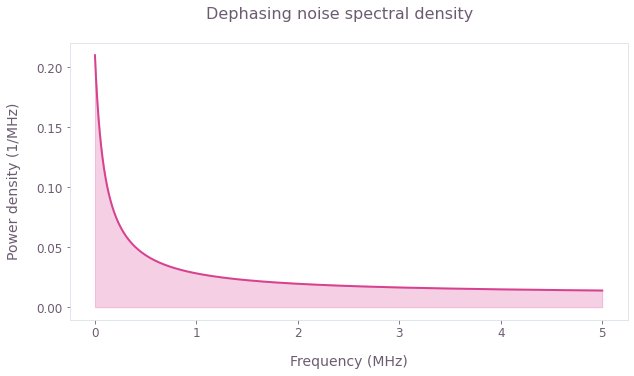

In [3]:
# Define the non-Markovian noise power spectrum.
def noise_spectrum(
    frequencies, cutoff_frequency, exponent=1, scale_factor=2e10, broadband_amplitude=0
):
    """
    Set up noise power spectral density.
    """
    return (
        scale_factor / (frequencies + cutoff_frequency) ** exponent
        + broadband_amplitude
    )


frequency_step = 1e3
frequencies = np.arange(0, 5e6, frequency_step)
power_densities = noise_spectrum(
    frequencies=frequencies, cutoff_frequency=1e5, exponent=1, broadband_amplitude=1e4
)

color = qv.QCTRL_STYLE_COLORS[4]
plt.plot(frequencies / 1e6, power_densities / 1e6, color=color)
plt.suptitle("Dephasing noise spectral density")
plt.fill_between(frequencies / 1e6, 0, power_densities / 1e6, color=color, alpha=0.25)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.show()

The noise PSD defined above produces a qubit with a T2 coherence time of about $20\mu$s, which is commensurate with the coherence times often encountered in superconducting systems.

## Reconstructing the noise PSD

### Generate diagnostic DD sequences with custom pulses

To perform the noise reconstruction, we define a series of CPMG sequences with a fixed duration of 10$\mu$s and varying orders (number of $\pi$ pulses in each sequence). This is one of the most straightforward ways of probing the noise PSD. It enables us to control the amplitude and width of the fundamental filter function peaks and keep them relatively constant for CPMG pulse sequences of different orders. 

The CPMG pulse sequences are constructed by concatenating a series of $\pi$ pulses appropriately spaced. An ideal sequence would be composed of perfect instantaneous $\pi$ pulses but, in reality, the pulses in the sequences are finite and can be shaped in different ways to satisfy hardware specifications or constraints. In this example, we chose to use DRAG pulses as they help minimize the leakage to the qubit's excited state and ensure that the quality of the filter functions is maintained. The DRAG $\pi/2$ and $\pi$ pulses defined below are directly imported from the [Q-CTRL Open Controls library](https://github.com/qctrl/open-controls) and converted into the appropriate Boulder Opal format for later use. 

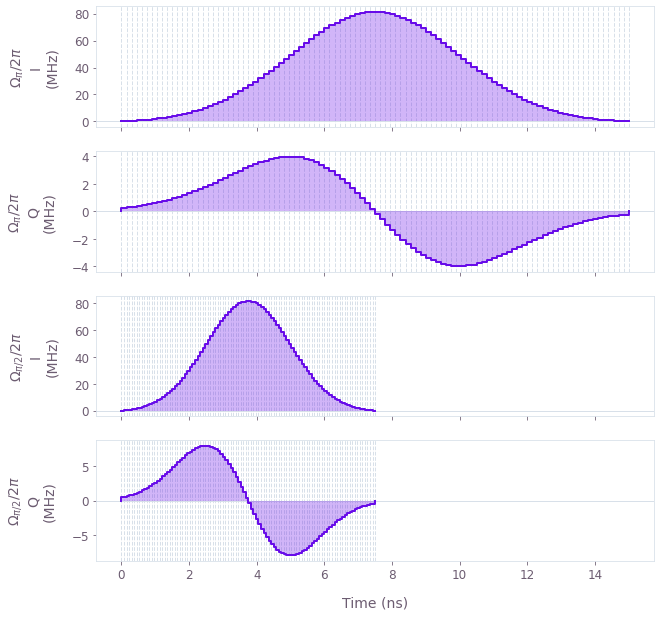

In [4]:
def convert_pulse(pulse):
    """
    Convert a pulse in Open Controls format to Boulder Opal format.
    """
    return {
        "values": pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
        "durations": pulse.durations,
    }


omega_max = 2 * np.pi * 100e6  # rad.Hz, transmon Rabi frequency

# DRAG pulses
segment_count = 100

rabi_rotation = np.pi / 1
pi_pulse = oc.new_drag_control(
    rabi_rotation=rabi_rotation,
    segment_count=segment_count,
    duration=3 * (rabi_rotation / omega_max),
    width=(rabi_rotation / omega_max) / 2,
    beta=2e-10,
)
pi_control = convert_pulse(pi_pulse)

rabi_rotation = np.pi / 2
pi_half_pulse = oc.new_drag_control(
    rabi_rotation=rabi_rotation,
    segment_count=segment_count,
    duration=3 * (rabi_rotation / omega_max),
    width=(rabi_rotation / omega_max) / 2,
    beta=2e-10,
)
pi_half_control = convert_pulse(pi_half_pulse)


qv.plot_controls(
    {r"$\Omega_{\pi}$": pi_control, r"$\Omega_{\pi/2}$": pi_half_control}, polar=False
)

The properties of the pulses can have an impact on the filtering characteristics of the DD sequences. For this reason, when defining these pulses, the filter functions of the sequences should be carefully inspected for systematic anomalies. It's useful to look out for occurrence of 0Hz peaks across different filter functions. Such anomalous peaks can introduce bias in the PSD estimates, especially in case of exponentially-shaped noise PSDs. 

With the custom pulses defined, we can write a function that generates the CPMG sequences using them.

In [5]:
def custom_CPMG(duration, order, pi_control, pi_half_control):
    """
    Generate a CPMG sequence using custom π and π/2 pulses.
    """

    pi_half_values = pi_half_control["values"]
    pi_values = pi_control["values"]

    pi_half_durations = pi_half_control["durations"]
    pi_half_duration = np.sum(pi_half_durations)
    pi_durations = pi_control["durations"]
    pi_duration = np.sum(pi_durations)

    if order == 0:
        seq_values = np.concatenate(
            (pi_half_values, [0], pi_half_values * np.exp(1j * np.pi))
        )
        seq_durations = np.concatenate(
            (pi_half_durations, [duration], pi_half_durations)
        )

    else:
        seq_values = np.tile(
            np.concatenate(([0.0], pi_values * np.exp(1j * np.pi / 2), [0.0])), order
        )
        tau = duration / order
        seq_durations = np.tile(
            np.concatenate(
                ([(tau - pi_duration) / 2], pi_durations, [(tau - pi_duration) / 2])
            ),
            order,
        )

        # Add 1st π/2.
        seq_durations[0] = seq_durations[0] - pi_half_duration / 2
        seq_durations = np.insert(seq_durations, 0, pi_half_durations)
        seq_values = np.insert(seq_values, 0, pi_half_values)

        # Add 2nd π/2.
        seq_durations[-1] = seq_durations[-1] - pi_half_duration / 2
        seq_durations = np.append(seq_durations, pi_half_durations)
        seq_values = np.append(seq_values, pi_half_values * np.exp(1j * np.pi))

    return {"durations": seq_durations, "values": seq_values}

Using the previous function, we define a list of CPMG sequences and plot one of them as an example.  

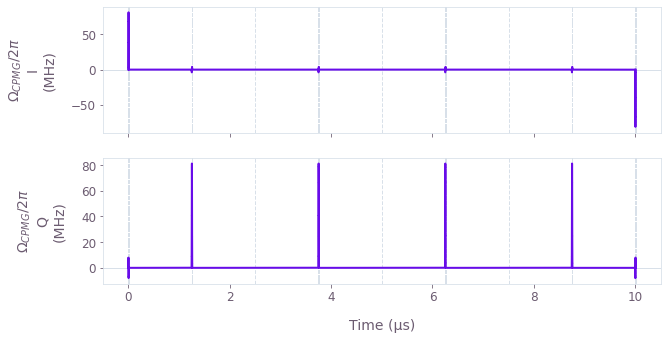

In [6]:
CPMG_sequence_duration = 10e-6  # s
CPMG_sequence_orders = np.arange(0, 40, 2)

CPMG_controls = [
    custom_CPMG(CPMG_sequence_duration, order, pi_control, pi_half_control)
    for order in CPMG_sequence_orders
]

# Plot a particular sequence.
qv.plot_controls({r"$\Omega_{CPMG}$": CPMG_controls[2]}, polar=False)
plt.show()

Note that various classes of DD sequences can be chosen for noise reconstruction depending on the characteristics of the system. We picked CPMG in this example because of its simplicity and high degree of efficiency in filtering dephasing noise. However, if there were Rabi rate fluctuations in the controls acting on the system, for example, we would pick a sequence with higher robustness to this Rabi rate noise, such as the XY8 sequence.

### Compute filter functions

Next, we calculate the filter function associated with each pulse sequence. See the [How to calculate and use filter functions](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-calculate-and-use-filter-functions-for-arbitrary-controls) user guide for more details.

In [7]:
graph = bo.Graph()

a = graph.annihilation_operator(dim)
n = graph.number_operator(dim)

ff_names = [f"filter_function_{idx}" for idx in range(len(CPMG_controls))]
for name, control in zip(ff_names, CPMG_controls):
    duration = np.sum(control["durations"])
    drive_term = graph.hermitian_part(graph.pwc(**control) * a)
    drift_term = -alpha * (n @ n - n) / 2
    noise = graph.constant_pwc(constant=n, duration=duration)

    hamiltonian = drive_term + drift_term
    graph.filter_function(
        control_hamiltonian=hamiltonian,
        noise_operator=noise,
        frequencies=frequencies,
        sample_count=2000,
        projection_operator=np.diag([1, 1, 0]),
        name=name,
    )

result = bo.execute_graph(
    graph=graph, output_node_names=ff_names, execution_mode="EAGER"
)["output"]

filter_functions = np.array([result[name]["inverse_powers"] for name in ff_names])

Your task (action_id="1828086") is queued.
Your task (action_id="1828086") has started.
Your task (action_id="1828086") has completed.


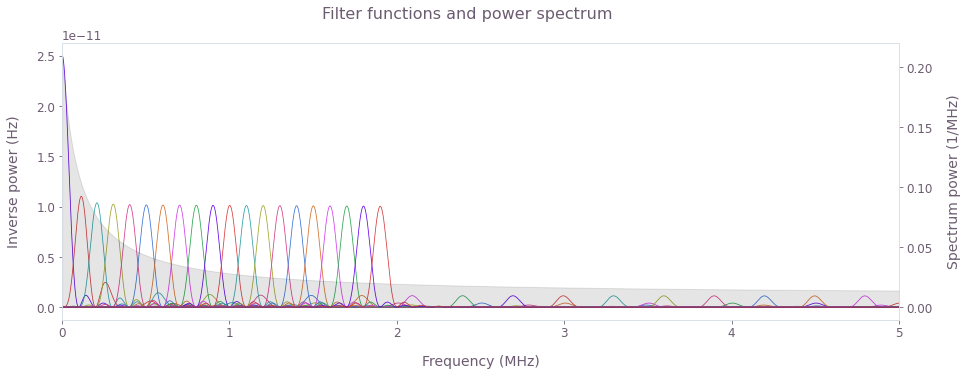

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(frequencies / 1e6, filter_functions.T, linewidth=0.8)

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Inverse power (Hz)")
fig.suptitle("Filter functions and power spectrum")
ax.set_xlim([0, 5])

ax2 = ax.twinx()
ax2.fill_between(frequencies / 1e6, power_densities / 1e6, 0, alpha=0.1, color="k")
ax2.set_ylabel("Spectrum power (1/MHz)")

plt.show()

Observe the fundamental peaks for the different CPMG filter functions (colored lines) interrogating the spectral window of interest. Note that the 0 order peak corresponds to the Ramsey sequence. The FWHM of filter function peaks acts a natural limit to spectral resolution. Longer sequence durations produce narrower peeks requiring use of higher order sequences to sample the same spectral window. Ultimately, the maximal frequency that can be sampled is limited by the duration of the $\pi$ pulses.

The key to noise reconstruction is making the fundamental filter function peaks overlap adequately to ensure they sample the noise PSD uniformly, as in the figure above. Note that in general, DD sequences of different durations or classes can be mixed together in our reconstruction method. However, in such cases the sampling coverage should be carefully managed so as to ensure no part of the interrogation window is left undersampled, that is, devoid of overlapping fundamental filter function peaks.

Also note that the CPMG, as well as other DD sequences, present higher order harmonics in addition to their main peak (see the smaller peaks in the plot). Those with significant presence outside the interrogation region will cause spectral leakage and lead to artifacts in the reconstructed spectrum. This can be especially problematic in reconstruction of power spectra containing complex features. In such cases, spectral leakage can be suppressed by using Slepian controls in place of DD sequences, as described in [this application note](https://docs.q-ctrl.com/boulder-opal/application-notes/performing-narrow-band-magnetic-field-spectroscopy-with-nv-centers).

### Apply sequences and perform measurements

In a real experiment, the next step would be to apply the set of diagnostic DD sequences to the qubit and measure its population.
Here, however, we will simulate a series of experiments where the final populations are measured after the application of CPMG sequences of various orders.

We calculate the evolution of the system under each pulse sequence and measure the probabilities of the different transmon states at the end, averaged over an ensemble of different noise samples.

In [9]:
noise_trajectory_count = 1000
initial_state = np.array([1, 0, 0])

graph = bo.Graph()

names = [f"probabilities_{idx}" for idx in range(len(CPMG_controls))]
for name, control in zip(names, CPMG_controls):
    # Create Hamiltonian.
    hamiltonian = create_hamiltonian(
        graph=graph,
        control=control,
        noise_power_densities=power_densities,
        noise_frequency_step=frequency_step,
        noise_trajectory_count=noise_trajectory_count,
    )

    # Evolve intial state.
    unitaries = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=np.array([np.sum(control["durations"])])
    )
    evolved_ensemble = unitaries @ initial_state[:, None]

    # Average final probabilities.
    probabilities_ensemble = graph.abs(evolved_ensemble[:, 0, :, 0]) ** 2
    probabilities = graph.sum(probabilities_ensemble, axis=0) / noise_trajectory_count
    probabilities.name = name

result = bo.execute_graph(graph=graph, output_node_names=names)

CPMG_probabilities = np.array([result["output"][name]["value"] for name in names])

Your task (action_id="1828090") is queued.
Your task (action_id="1828090") has started.
Your task (action_id="1828090") has completed.


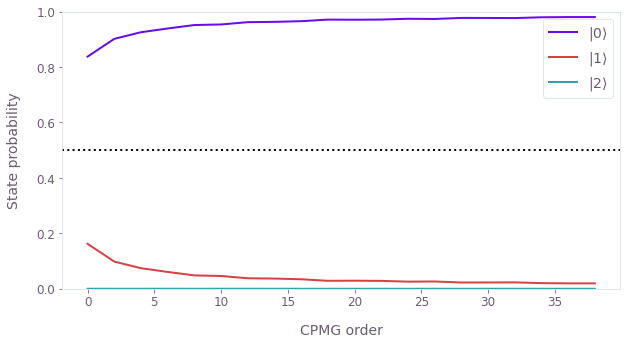

In [10]:
plt.plot(CPMG_sequence_orders, CPMG_probabilities)
plt.axhline(0.5, ls=":", color="black")

plt.xlabel("CPMG order")
plt.ylabel("State probability")
plt.ylim([0, 1])
plt.legend(labels=[rf"$|{idx}\rangle$" for idx in range(3)])
plt.show()

### Process the measurements

We now construct a bounded infidelity metric $I_B=1-P_0$, where $P_0$ is the probability of the $|0\rangle $ state. In experiments, the response of this metric to noise is nonlinear and naturally defined in the interval [0.0,0.5]. Note that the filter function formalism assumes unbounded linear response to noise. To use filter functions with greater accuracy, we first linearize the measurement values, as done below (see [Soare et al.](https://doi.org/10.1038/nphys3115) for more details).

In [11]:
bounded_infidelity = 1 - CPMG_probabilities[:, 0]
unbounded_infidelity = -np.log(1 - bounded_infidelity * 2) / 2

Ideally, the duration of the sequence should be significantly shorter than the qubit's T1 coherence time to minimize the impact of T1 decay over the evolution of the sequence. For durations comparable to the qubit's T1 time, the effect should be accounted for by rescaling the signal based on the decay envelope.

### Reconstruct the noise PSD

We now reconstruct the noise in several simple steps. First, we select the frequency band that corresponds to the spectral range being interrogated by the filter function peaks - this is the spectral window over which we have the ability to reconstruct the PSD.

In [12]:
filter_function_peaks = frequencies[np.argmax(filter_functions, axis=1)]
lower_sample_frequency = filter_function_peaks[0]
upper_sample_frequency = filter_function_peaks[-1]

sample_selection = (frequencies >= lower_sample_frequency) & (
    frequencies <= upper_sample_frequency
)
sample_frequencies = frequencies[sample_selection]
sample_spectrum = power_densities[sample_selection]

Next, we pass the measurements along with their corresponding filter functions `boulderopal.noise_reconstruction.reconstruct`, as described in the [How to perform noise spectroscopy on arbitrary noise channels](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-perform-noise-spectroscopy-on-arbitrary-noise-channels) user guide.
Here we use convex optimization to perform a non-parametric spectrum reconstruction without specific assumptions about the shape of the noise PSD.

In [13]:
shot_noise = 1e-4

# Configure CVX reconstruction method.
method = bo.noise_reconstruction.ConvexOptimization(
    power_density_lower_bound=0,
    power_density_upper_bound=1e6,
    regularization_hyperparameter=1e-11,
)

sample_filter_functions = [
    bo.noise_reconstruction.FilterFunction(sample_frequencies, filter_function)
    for filter_function in filter_functions[:, sample_selection]
]

result = bo.noise_reconstruction.reconstruct(
    filter_functions=[sample_filter_functions],
    infidelities=unbounded_infidelity,
    infidelity_uncertainties=np.ones_like(unbounded_infidelity) * shot_noise,
    method=method,
)

# Extract reconstructed PSD.
reconstructed_spectrum = result["output"][0]["psd"]

Your task (action_id="1828092") is queued.
Your task (action_id="1828092") has started.
Your task (action_id="1828092") has completed.


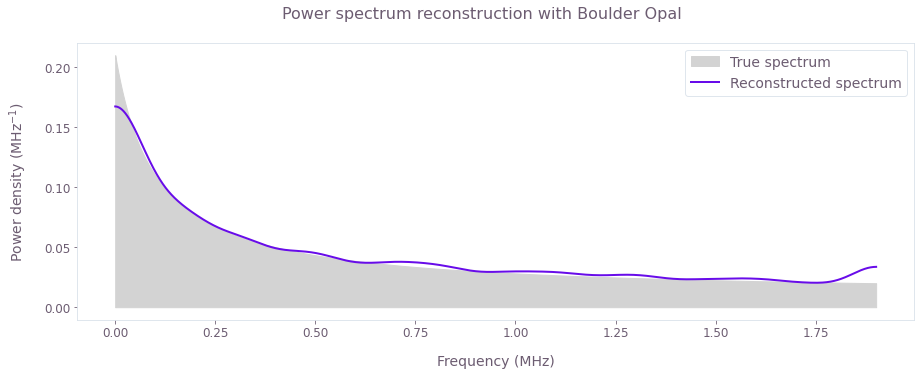

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.fill_between(
    sample_frequencies / 1e6,
    sample_spectrum / 1e6,
    0,
    color="lightgray",
    label="True spectrum",
)
ax.plot(
    sample_frequencies / 1e6,
    reconstructed_spectrum / 1e6,
    "-",
    label="Reconstructed spectrum",
)

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power density (MHz$^{-1}$)")
ax.legend()
fig.suptitle("Power spectrum reconstruction with Boulder Opal")
plt.show()

Here we can compare the reconstructed spectrum (solid line) with the true noise PSD used to simulate the results (shaded). 

Note the discrepancies near each of the extremities of the spectrum. These artifacts originate from a reduced sampling level. The sides of the band are probed by a single filter function in contrast to the middle, where every frequency point is sampled by at least two overlapping filter function peaks. Those artifacts can be reduced by narrowing the spectral width of the filter function peaks. Furthermore, these reconstructed results can be used to propose an analytic model of noise PSD with relatively few degrees of freedom and perform a parametric reconstruction that would resolve such artifacts.